In [ ]:
Step-by-Step Oracle database to Postgresql Migration 
---------------------------------------------------------------

source database oracle running on EC2 server 
----------------------------------------------

SELECT INSTANCE_NAME,HOST_NAME,VERSION,STATUS FROM "V$INSTANCE"
"INSTANCE_NAME",    "HOST_NAME",                                    "VERSION",      "STATUS"
bosdbdev,           ip-10-50-10-222.ap-south-1.compute.internal,    "19.0.0.0.0",   OPEN


target database postgres running on AWS RDS 
----------------------------------------

select version();
"version"
"PostgreSQL 16.4 on x86_64-pc-linux-gnu, compiled by gcc (GCC) 7.3.1 20180712 (Red Hat 7.3.1-17), 64-bit"

select d.datname ,u.usename , t.spcname 
from pg_catalog.pg_database d join pg_catalog.pg_user u on d.datdba = u.usesysid 
join pg_catalog.pg_tablespace t on  d.dattablespace = t."oid"
where d.datname = 'bosdb';
"datname",  "usename",  "spcname"
bosdb,      rds_master, pg_default


In [ ]:
Step 1: Install the SQL Drivers and AWS Schema Conversion Tool on Your Local Computer
------------------------------------------------------------------------------------------------

C:\Users\Arvind\Desktop\udemy_courses\ojdbc10.jar   - oracle 

C:\Users\Arvind\Desktop\udemy_courses\postgresql-42.2.19.jar   - postgresql 


aws-schema-conversion-tool-1.0.latest.zip 
AWS Schema Conversion Tool-1.0.676.msi 


Launch AWS SCT.
In AWS SCT, choose Global settings from Settings.
In Global settings, choose Driver, and then choose Browse for Oracle driver path. Locate the JDBC Oracle driver and choose OK.
Choose Browse for PostgreSQL driver path. Locate the JDBC PostgreSQL driver and choose OK.

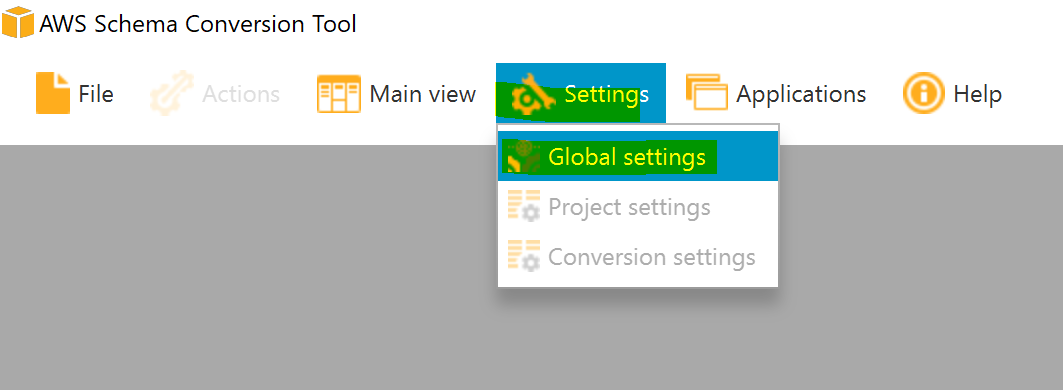

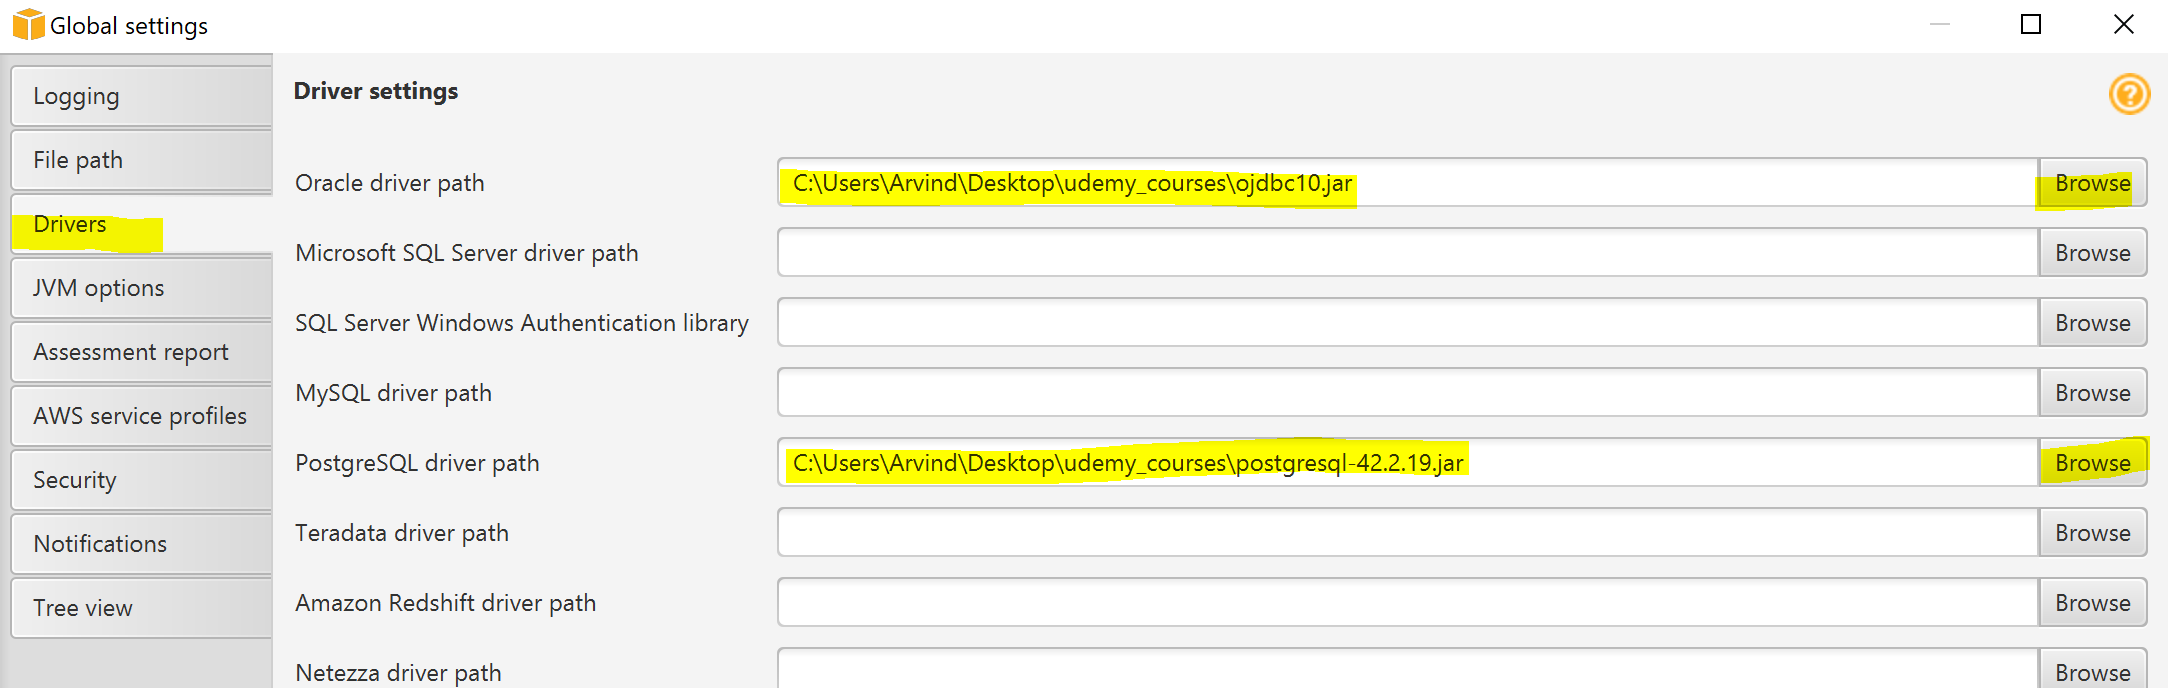

In [ ]:
Step 2: Configure Your Oracle Source Database
-------------------------------------------------------

Enable Archivelog 
--------------------------

To use Oracle as a source for AWS Database Migration Service (AWS DMS), you must first ensure that ARCHIVELOG MODE is on 
to provide information to LogMiner. 
AWS DMS uses LogMiner to read information from the archive logs so that AWS DMS can capture changes.

SQL> archive log list;
Database log mode              Archive Mode
Automatic archival             Enabled
Archive destination            USE_DB_RECOVERY_FILE_DEST

SQL> ! ls -rtl /u01/app/oracle/fast_recovery_area/BOSDBDEV/archivelog/2025_04_12/
-rw-r-----. 1 oracle oinstall 178162176 Apr 12 06:00 o1_mf_1_9_mzn0dbdj_.arc


Create a user for DMS 
-------------------------------------

Create or configure a database account to be used by AWS DMS. We recommend that you use an account with the minimal privileges 
required by AWS DMS for your AWS DMS connection. 
AWS DMS requires the following privileges.

SQL> create user oracle_dms_user identified by ******;

SQL> select 'GRANT SELECT ON '||owner||'.'||table_name||' TO oracle_dms_user; ' from dba_tables where owner in ('HR','CO');

SQL> @oracle_aws_dms_user_privileges.sql


Turn supplemental logging on 
---------------------------------------------

Run the following command to turn on supplemental logging at the database level, which AWS DMS requires:

SQL> ALTER DATABASE ADD SUPPLEMENTAL LOG DATA;

To capture change data, AWS DMS requires supplemental logging to be enabled on your source database. 
Minimal supplemental logging must be enabled at the database level.

Use the following command to enable identification key supplemental logging at the database level. 
The exception is if you allow AWS DMS to automatically add 
supplemental logging as needed or enable key-level supplemental logging at the table level:

SQL> ALTER DATABASE ADD SUPPLEMENTAL LOG DATA (PRIMARY KEY) COLUMNS;


Create a user for AWS SCT
-----------------------------------------------------

SQL> CREATE USER oracle_sct_user IDENTIFIED BY *****;
SQL> GRANT CONNECT TO oracle_sct_user;
SQL> GRANT SELECT_CATALOG_ROLE TO oracle_sct_user;
SQL> GRANT SELECT ANY DICTIONARY TO oracle_sct_user;


In [ ]:
Step 3: Configure Your PostgreSQL Target Database
----------------------------------------------------------------

create schemas 
----------------------

If the schemas you are migrating do not exist on the PostgreSQL database, then create the schemas.

create schema co;
create schema hr;


create DMS user 
---------------------------

Create the AWS DMS user to connect to your target database, and grant Superuser or the necessary individual 
privileges (or use the master username for RDS).

create user postgres_dms_user with password '******';
grant rds_superuser to postgres_dms_user;


Create a user for AWS SCT.
--------------------------------

CREATE USER postgres_sct_user WITH PASSWORD '*****';

GRANT CONNECT ON DATABASE bosdb TO postgres_sct_user;
GRANT USAGE ON SCHEMA co TO postgres_sct_user;
GRANT SELECT ON ALL TABLES IN SCHEMA co TO postgres_sct_user;
GRANT ALL ON ALL SEQUENCES IN SCHEMA co TO postgres_sct_user;
GRANT USAGE ON SCHEMA hr TO postgres_sct_user;
GRANT SELECT ON ALL TABLES IN SCHEMA hr TO postgres_sct_user;
GRANT ALL ON ALL SEQUENCES IN SCHEMA hr TO postgres_sct_user;
